In [72]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [73]:
training_data = pd.read_csv("training.csv", header=None, usecols=[0,1,2,3], names=['open', 'high', 'low', 'close'])
df = pd.DataFrame(training_data)
training_data.head()

,open,high,low,close
0,186.73,188.71,186.00,186.30
1,185.57,186.33,184.94,185.54
2,184.81,185.03,183.10,184.66
3,184.39,184.48,182.31,182.54
4,182.20,182.27,180.27,181.59


In [74]:
testing_data = pd.read_csv("testing.csv", header=None, usecols=[0,1,2,3], names=['open', 'high', 'low', 'close'])
testing_data.head()

,open,high,low,close
0,154.40,155.02,152.91,154.76
1,155.96,156.80,155.07,156.46
2,156.45,156.74,154.68,155.35
3,154.10,156.22,154.09,154.10
4,153.59,154.45,153.26,153.57


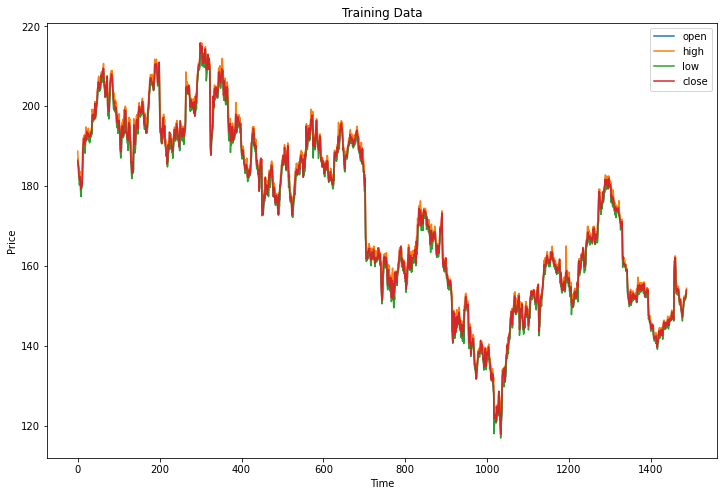

In [75]:
plot_cols = ['open', 'high', 'low', 'close']
plot_feature = training_data[plot_cols]

plot_feature.plot(figsize=(12, 8))
plt.title("Training Data")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [76]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

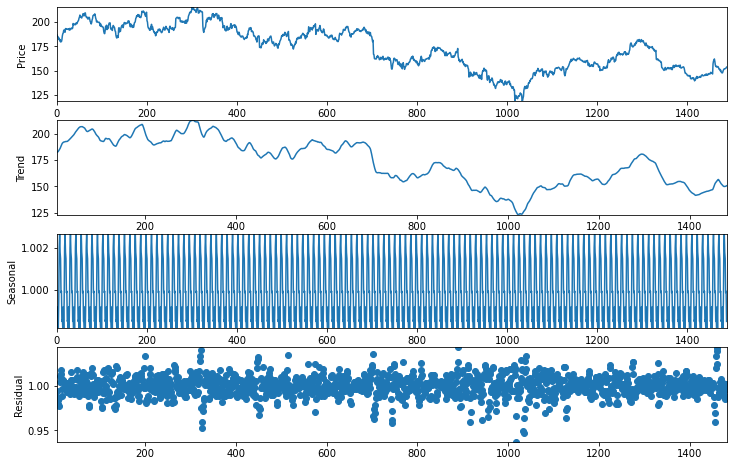

In [77]:
result = seasonal_decompose(plot_feature['open'], model='multiplicative', freq=12)
plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(result.observed, label='Price')
plt.ylabel('Price')
plt.margins(0)
plt.subplot(4,1,2)
plt.plot(result.trend)
plt.ylabel('Trend')
plt.margins(0)
plt.subplot(4,1,3)
plt.plot(result.seasonal)
plt.ylabel('Seasonal')
plt.margins(0)
plt.subplot(4,1,4)
plt.scatter(df.index,result.resid)
plt.ylabel('Residual')
plt.margins(0)


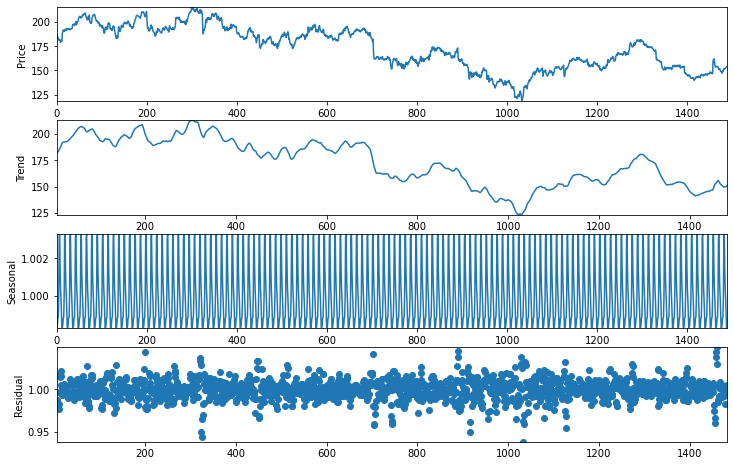

In [78]:
result = seasonal_decompose(plot_feature['close'], model='multiplicative', freq=12)
plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(result.observed, label='Price')
plt.ylabel('Price')
plt.margins(0)
plt.subplot(4,1,2)
plt.plot(result.trend)
plt.ylabel('Trend')
plt.margins(0)
plt.subplot(4,1,3)
plt.plot(result.seasonal)
plt.ylabel('Seasonal')
plt.margins(0)
plt.subplot(4,1,4)
plt.scatter(df.index,result.resid)
plt.ylabel('Residual')
plt.margins(0)


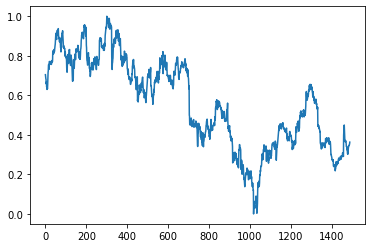

In [79]:
from sklearn.preprocessing import MinMaxScaler 
train_set = training_data['open']
test_set = testing_data['open']
sc = MinMaxScaler(feature_range = (0, 1))
train_set = train_set.values.reshape(-1,1)
training_set_scaled = sc.fit_transform(train_set)
plt.plot(training_set_scaled)

In [80]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout,BatchNormalization

X_train = [] 
y_train = []
for i in range(10,len(train_set)):
    X_train.append(training_set_scaled[i-10:i-1, 0]) 
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train) 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

keras.backend.clear_session()
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences=True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 100, activation='relu'))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [81]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 9, 100)            40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
1478/1478 [==============================] - 1s 982us/step - loss: 0.0254
Epoch 2/100
1478/1478 [==============================] - 1s 505us/step - loss: 0.0025
Epoch 3/100
1478/1478 [==============================] - 1s 522us/step - loss: 0.0023
Epoch 4/100
1478/1478 [==============================] - 1s 590us/step - loss: 0.0024
Epoch 5/100
1478/1478 [==============================] - 1s 628us/step - loss: 0.0023
Epoch 6/100
1478/1478 [==============================] - 1s 598us/step - loss: 0.0023
Epoch 7/100
1478/1478 [==============================] - 1s 625us/step - loss: 0.0023
Epoch 8/100
1478/1478 [==============================] - 1s 616us/step - loss: 0.0023
Epoch 9/100
1478/1478 [==============================] - 1s 652us/step - loss: 0.0021
Epoch 10/100
1478/1478 [==============================] - 1s 645us/step - loss: 0.0021
Epoch 11/100
1478/1478 [==============================] - 1s 650us/step - loss: 0.0020
Epoch 12/100
1478/1478 [============================

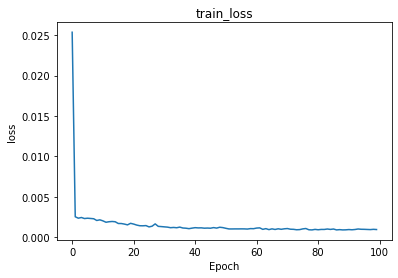

In [82]:
history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 16)
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot( history.history["loss"])

In [83]:
dataset_total = pd.concat((training_data['open'], testing_data['open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test_set) - 10:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(10, len(inputs)):
    X_test.append(inputs[i-10:i-1, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

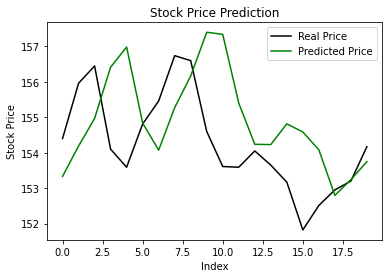

In [84]:
plt.plot(testing_data['open'].values, color = 'black', label = 'Real Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()